In [9]:
# !pip install --upgrade numpy
# !pip install --upgrade mxnet==1.9.1  # Downgrade mxnet to a version that is compatible with your numpy version

import numpy as np
np.bool = np.bool_  # Add this line to resolve the issue
import os
import cv2
import pandas as pd
import pickle
import mxnet as mx
import pickle
from google.colab import drive
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt

In [10]:
drive.mount('/content/drive')
path = '/content/drive/MyDrive/biometric'
os.listdir(path)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


['dataset', '2dface_preprocessing.ipynb']

In [11]:
#face detection model
faceDetectionModel = '/content/drive/MyDrive/test_cv/project_titv/models/res10_300x300_ssd_iter_140000_fp16.caffemodel'
#mô tả kiến trúc
faceDetectionProto = '/content/drive/MyDrive/test_cv/project_titv/models/deploy.prototxt.txt'
#mô tả khuôn mặt
faceDescriptor = '/content/drive/MyDrive/test_cv/project_titv/models/openface.nn4.small2.v1.t7'
#sử dụng opencv dnn đọc mô hình nhận diện khuôn mặt
detectorModel = cv2.dnn.readNetFromCaffe(faceDetectionProto, faceDetectionModel)

#đọc mô hình mô tả khuôn mặt từ file Torch
descriptorModel= cv2.dnn.readNetFromTorch(faceDescriptor)

In [12]:
def myDetect(image_input):

    # Kiểm tra loại đầu vào
    if isinstance(image_input, str):  # Nếu là đường dẫn
        img1 = cv2.imread(image_input)
        if img1 is None:
            raise ValueError(f"Không thể đọc ảnh từ đường dẫn: {image_input}")
    elif isinstance(image_input, np.ndarray):  # Nếu là NumPy array
        img1 = image_input.copy()
    else:
        raise TypeError("Dữ liệu đầu vào phải là đường dẫn hoặc NumPy array.")

    # Copy ảnh
    image = img1.copy()

    # Lấy chiều cao và chiều rộng
    h, w = image.shape[:2]

    # Chuẩn bị dữ liệu đầu vào cho mô hình nhận diện khuôn mặt
    imgBlob = cv2.dnn.blobFromImage(image, 1.0, (300, 300), [104, 117, 123], swapRB=False, crop=False)

    # Thiết lập đầu vào cho mô hình
    detectorModel.setInput(imgBlob)

    # Thực hiện việc nhận diện khuôn mặt
    detections = detectorModel.forward()

    # Kiểm tra xem có khuôn mặt nào không
    if len(detections) > 0:
        # Chọn khuôn mặt có độ tin cậy cao nhất (confidence)
        i = np.argmax(detections[0, 0, :, 2])  # Giá trị thứ 2 trong 7 giá trị cuối cùng => confidence
        confidence = detections[0, 0, i, 2]

        # Kiểm tra độ tin cậy có lớn hơn 0.5
        if confidence > 0.5:
            # Tính toán hộp bao quanh khuôn mặt
            box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
            (startX, startY, endX, endY) = box.astype('int')

            # Trích xuất vùng ảnh chứa khuôn mặt ra
            roi = image[startY:endY, startX:endX]

            # Hiển thị vùng ảnh khuôn mặt (tuỳ chọn)
            cv2_imshow(roi)

            # Chuẩn bị dữ liệu đầu vào cho mô hình trích xuất đặc trưng
            faceBlob = cv2.dnn.blobFromImage(roi, 1/255, (96, 96), (0, 0, 0), swapRB=True, crop=True)

            # Thiết lập đầu vào cho mô hình
            descriptorModel.setInput(faceBlob)

            # Thực hiện việc trích xuất đặc trưng
            vectors = descriptorModel.forward()
            return vectors

    # Trả về None nếu không phát hiện khuôn mặt
    return None


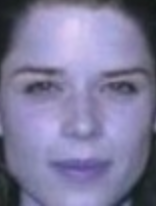

Trích xuất đặc trưng thành công: Nhãn = 9


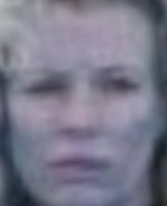

Trích xuất đặc trưng thành công: Nhãn = 6


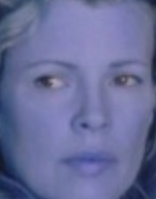

Trích xuất đặc trưng thành công: Nhãn = 6


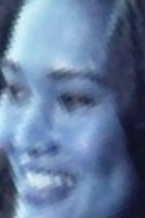

Trích xuất đặc trưng thành công: Nhãn = 10


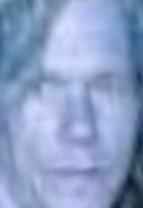

Trích xuất đặc trưng thành công: Nhãn = 3


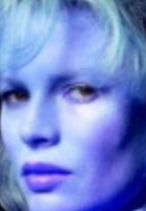

Trích xuất đặc trưng thành công: Nhãn = 6


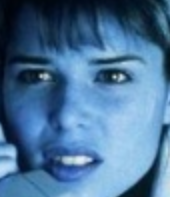

Trích xuất đặc trưng thành công: Nhãn = 9


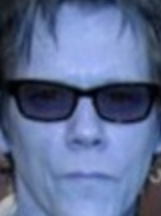

Trích xuất đặc trưng thành công: Nhãn = 3


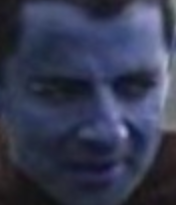

Trích xuất đặc trưng thành công: Nhãn = 2


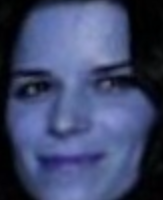

Trích xuất đặc trưng thành công: Nhãn = 9


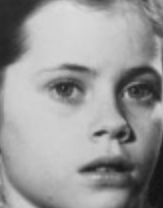

Trích xuất đặc trưng thành công: Nhãn = 4


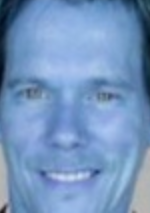

Trích xuất đặc trưng thành công: Nhãn = 3


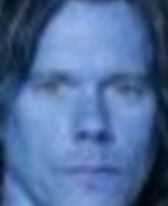

Trích xuất đặc trưng thành công: Nhãn = 3


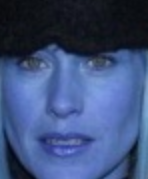

Trích xuất đặc trưng thành công: Nhãn = 1


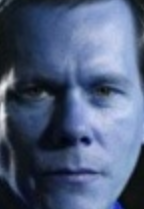

Trích xuất đặc trưng thành công: Nhãn = 3


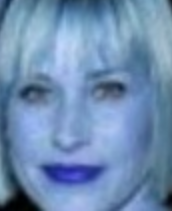

Trích xuất đặc trưng thành công: Nhãn = 1


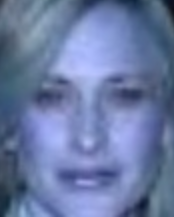

Trích xuất đặc trưng thành công: Nhãn = 1


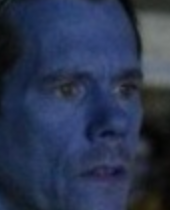

Trích xuất đặc trưng thành công: Nhãn = 3


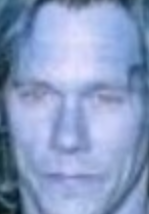

Trích xuất đặc trưng thành công: Nhãn = 3


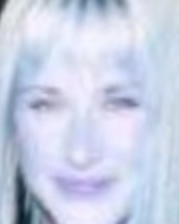

Trích xuất đặc trưng thành công: Nhãn = 1


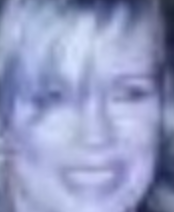

Trích xuất đặc trưng thành công: Nhãn = 6


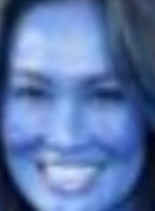

Trích xuất đặc trưng thành công: Nhãn = 10


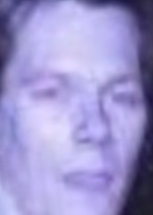

Trích xuất đặc trưng thành công: Nhãn = 3


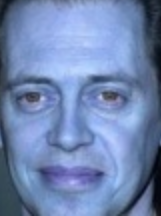

Trích xuất đặc trưng thành công: Nhãn = 8


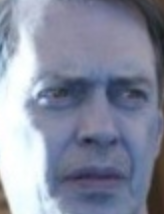

Trích xuất đặc trưng thành công: Nhãn = 8


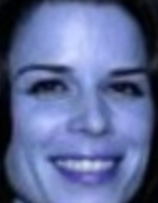

Trích xuất đặc trưng thành công: Nhãn = 9


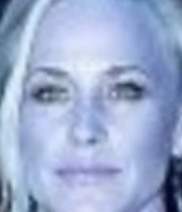

Trích xuất đặc trưng thành công: Nhãn = 1


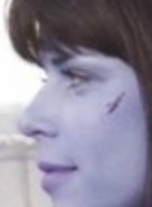

Trích xuất đặc trưng thành công: Nhãn = 9


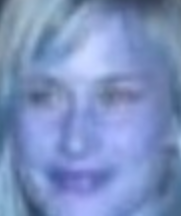

Trích xuất đặc trưng thành công: Nhãn = 1


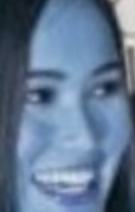

Trích xuất đặc trưng thành công: Nhãn = 10


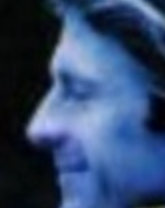

Trích xuất đặc trưng thành công: Nhãn = 6


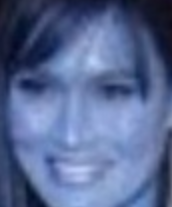

Trích xuất đặc trưng thành công: Nhãn = 10


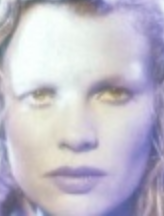

Trích xuất đặc trưng thành công: Nhãn = 6


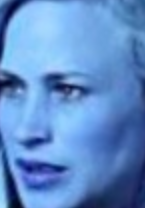

Trích xuất đặc trưng thành công: Nhãn = 1


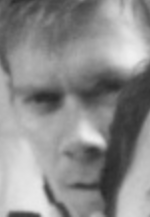

Trích xuất đặc trưng thành công: Nhãn = 3


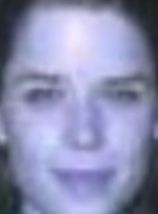

Trích xuất đặc trưng thành công: Nhãn = 9


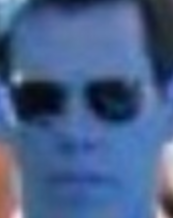

Trích xuất đặc trưng thành công: Nhãn = 3


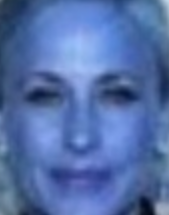

Trích xuất đặc trưng thành công: Nhãn = 1


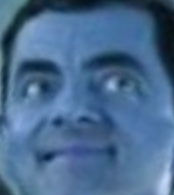

Trích xuất đặc trưng thành công: Nhãn = 2


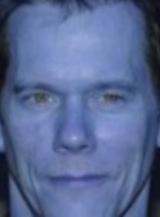

Trích xuất đặc trưng thành công: Nhãn = 3


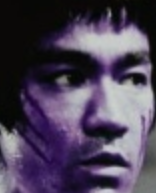

Trích xuất đặc trưng thành công: Nhãn = 0


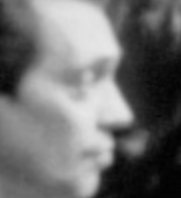

Trích xuất đặc trưng thành công: Nhãn = 8


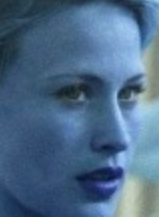

Trích xuất đặc trưng thành công: Nhãn = 1


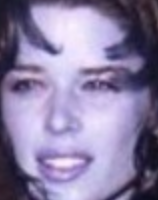

Trích xuất đặc trưng thành công: Nhãn = 9


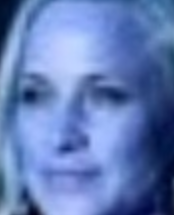

Trích xuất đặc trưng thành công: Nhãn = 1


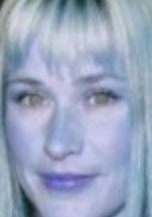

Trích xuất đặc trưng thành công: Nhãn = 1


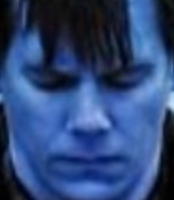

Trích xuất đặc trưng thành công: Nhãn = 3


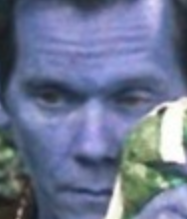

Trích xuất đặc trưng thành công: Nhãn = 3


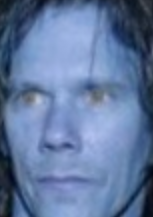

Trích xuất đặc trưng thành công: Nhãn = 3


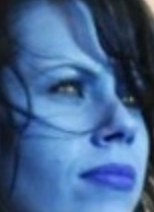

Trích xuất đặc trưng thành công: Nhãn = 4


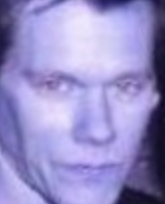

Trích xuất đặc trưng thành công: Nhãn = 3


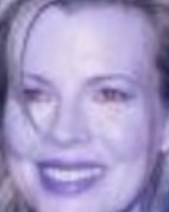

Trích xuất đặc trưng thành công: Nhãn = 6


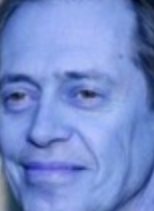

Trích xuất đặc trưng thành công: Nhãn = 8


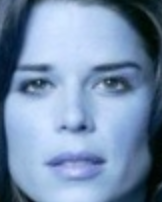

Trích xuất đặc trưng thành công: Nhãn = 9


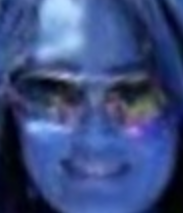

Trích xuất đặc trưng thành công: Nhãn = 10


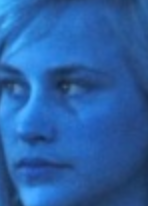

Trích xuất đặc trưng thành công: Nhãn = 1


KeyboardInterrupt: 

In [13]:
faces_path = '/content/drive/MyDrive/biometric/dataset/casia-webface/train.rec'
data = dict(data=[], label=[])

# Mở file .rec bằng ImageRecordIter
data_iter = mx.io.ImageRecordIter(
    path_imgrec=faces_path,
    data_shape=(3, 224, 224),  # Định dạng kênh, chiều cao, chiều rộng
    batch_size=1,             # Số lượng ảnh trong mỗi batch
    shuffle=True              # Trộn dữ liệu
)

for batch in data_iter:
    try:
        # Lấy ảnh từ batch
        img = batch.data[0][0].asnumpy()
        img = np.transpose(img, (1, 2, 0))  # Chuyển đổi từ (C, H, W) -> (H, W, C)

        # Gọi hàm myDetect với NumPy array
        vector = myDetect(img)

        # Lấy nhãn từ batch
        label = int(batch.label[0].asnumpy()[0])

        # Kiểm tra nếu trích xuất đặc trưng thành công
        if vector is not None:
            data['data'].append(vector)
            data['label'].append(label)
            print(f"Trích xuất đặc trưng thành công: Nhãn = {label}")
    except Exception as e:
        print(f"Lỗi: {e}")
        continue


In [ ]:
fileName = ('/content/drive/MyDrive/biometric/2dface_features.pickle')
pickle.dump(data, open(fileName, mode='wb'))